# Simulation Analysis


### 1. Import Packages
Here we will be using the reading and writing tools that come with the ParFlow tools package.  

In [1]:
import xarray as xr
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

import parflow as pf
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
from parflow import Run
import parflow.tools.hydrology as hydro

#setting the directory name that we will read our outputs from
run_name = 'LW_CLM'
run_dir = get_absolute_path(f'outputs/{run_name}')

####  2. Read in the domain properties
First we will load the run from the pfidb file and get the properties using the [data_accessor](https://parflow-docs.readthedocs.io/en/latest/tutorials/data_accessor.html?highlight=data_accessor) and by reading out the keys we need from the model object. 


In [2]:
run = Run.from_definition(f'{run_dir}/{run_name}.pfidb')
data = run.data_accessor
nt = len(data.times)
nx = data.shape[2]
ny = data.shape[1]
nz = data.shape[0]
dx = data.dx
dy = data.dy
dz = data.dz

print(nt,nx,ny,nz,dx,dy,dz)

porosity = data.computed_porosity 
specific_storage = data.specific_storage 
mannings = run.Mannings.Geom.domain.Value

## remove input filenames for TopoSlopes to force the data accessor to read the output slopes
## this fixes a windows issue
run.TopoSlopesX.FileName = None
run.TopoSlopesY.FileName = None

slopex = data.slope_x 
slopey = data.slope_y 
mask = data.mask

# formatting the mask so that values outside the domain are NA and inside the domain are 1
nanmask=mask.copy()
nanmask[nanmask == 0] = 'NaN'
nanmask[nanmask > 0] = 1

Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
  - nc
  - nr
  - nt
  - sw_ini
  - qflx_tran_vegm
  - scalez
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
  - sdep
  - manning
  - rout
  - cout
  - sovout
73 64 32 10 1000.0 1000.0 [1.0e+03 1.0e+02 5.0e+01 2.5e+01 1.0e+01 5.0e+00 1.0e+00 6.0e-01 3.0e-01
 1.0e-01]


#### 4. Read the simulation output files


In [3]:
#list all pressure files from outputs
lw_press_files = glob(f'{run_dir}/*out.press*.pfb')
#print(lw_press_files)
#read in all pressure files into a 3D NParray
pressure_arrays = pf.read_pfb_sequence(lw_press_files) * nanmask

#list all saturation files from outputs
lw_satur_files = glob(f'{run_dir}/*out.satur*.pfb')
#read in all pressure files into a 3D NParray
saturation_arrays = pf.read_pfb_sequence(lw_satur_files) * nanmask

#### 5. Calculate water balance
We will be using the hydrology tools to calculate the water balance. You can find more information on that [here](https://parflow-docs.readthedocs.io/en/latest/tutorials/hydrology.html) 

In [4]:
subsurface_storage = np.zeros(nt)
surface_storage = np.zeros(nt)
wtd = np.zeros((nt, ny, nx))
et = np.zeros(nt)
overland_flow = np.zeros((nt, ny, nx))
data.time = 0

for i, (pressure, saturation) in enumerate(zip(pressure_arrays, saturation_arrays)):
    subsurface_storage[i, ...] = np.sum(hydro.calculate_subsurface_storage(porosity, pressure, saturation, specific_storage, dx, dy, dz, mask = nanmask),axis=(0, 1, 2))
    # total surface storage for this time step is the summation of substorage surface across all x/y slices
    surface_storage[i, ...] = np.sum( hydro.calculate_surface_storage(pressure, dx, dy, mask = nanmask),axis=(0, 1))
    wtd[i, ...] = hydro.calculate_water_table_depth(pressure, saturation, dz)
    
    data.time = i
    if i != 0:
        if data.et is not None:
            # total ET for this time step is the summation of ET values across all x/y/z slices
            et[i, ...] = np.sum(hydro.calculate_evapotranspiration(data.et, dx, dy, dz, mask = nanmask),axis=(0, 1, 2))

 
    overland_flow[i, ...] = hydro.calculate_overland_flow_grid(pressure, slopex, slopey, mannings, dx, dy, mask = nanmask)

### Plot Static maps of the simulation outputs

(73, 32, 64)
(73, 10, 32, 64)


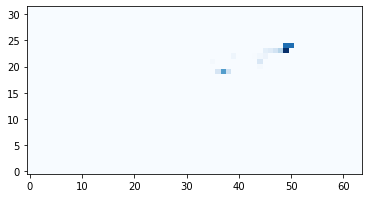

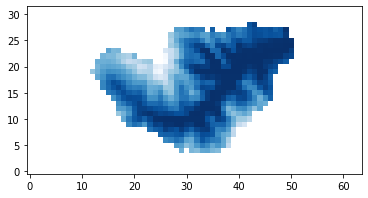

('eflx_lh_tot', 'eflx_lwrad_out', 'eflx_sh_tot', 'eflx_soil_grnd', 'qflx_evap_tot', 'qflx_evap_grnd', 'qflx_evap_soi', 'qflx_evap_veg', 'qflx_tran_veg', 'qflx_infl', 'swe_out', 't_grnd', 'qflx_qirr', 't_soil')


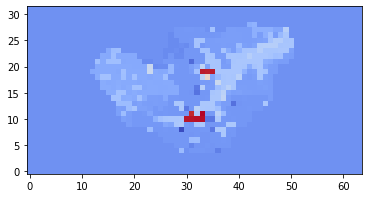

In [5]:
print(np.shape(overland_flow))
print(np.shape(pressure_arrays))

plt.imshow(overland_flow[72,:,:], cmap="Blues", origin='lower')
plt.show()
plt.imshow(wtd[72,:,:], cmap="Blues_r", origin='lower')
plt.show()

#print out all CLM variables avilable
print(data.clm_output_variables)
# set time
data.time = 50
# fileter out inactive cells
LH_plot = np.where(data.clm_output(field='eflx_lh_tot') > -99, data.clm_output(field='eflx_lh_tot'), 0.)
plt.imshow(LH_plot, cmap="coolwarm", origin='lower')
plt.show()

### plotting components of water balance

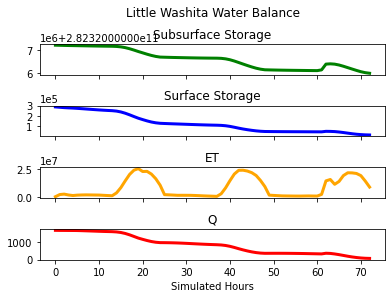

In [6]:
#plotting components of water balance
fig, axs = plt.subplots(4, sharex=True)
fig.suptitle('Little Washita Water Balance')
axs[0].plot(subsurface_storage, linewidth=3, color = "green")
axs[0].set_title("Subsurface Storage")
axs[1].plot(surface_storage, linewidth=3, color = "blue")
axs[1].set_title("Surface Storage")
axs[2].plot(et, linewidth=3, color = "orange")
axs[2].set_title("ET")
axs[3].plot(overland_flow[:,24,50], linewidth=3, color = "red")
axs[3].set_title("Q")
plt.xlabel('Simulated Hours')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.85, 
                    wspace=0.7, 
                    hspace=1.0)
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))